In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from torch.autograd import grad
import random
import matplotlib
import matplotlib.pyplot as plt
import pickle


In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Constants
SEED = 123
N_TRAIN = 5000
N_VAL = 1000
BATCH_SIZE = 32
BETA = 0.01
MIN_DELTA = 0.0001
PATIENCE = 25
NUM_EPOCHS = 1000


# Functions
def set_seed(seed_value):
    """Set seed for reproducibility."""
    torch.manual_seed(seed_value)
    np.random.seed(seed_value)
    random.seed(seed_value)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

def compute_loss(mod, x, y, loss_fn, lambda_val=0.0):
    yhat = mod(x)
    if lambda_val == 0.0:
        return loss_fn(yhat, y)
    else:
        reg_term = torch.norm(torch.cat([param.view(-1) for param in mod.parameters()]), p=2) ** 2
        return loss_fn(yhat, y) + 0.5 * torch.exp(lambda_val) * reg_term

def conjugate_gradient(A, b, mod, tol, max_iter):
    x = torch.ones_like(b)
    r = b - grad_and_flat(A, mod.parameters(), x)
    p = r.clone()
    rs_old = torch.dot(r, r)

    for i in range(max_iter):
        Ap = torch.dot(p, grad_and_flat(A, mod.parameters(), p))
        alpha = rs_old/Ap
        x = x + alpha*p
        r = r -alpha*p
        rs_new = torch.dot(r, r)

        if torch.sqrt(rs_new) < tol:
            break
        beta = rs_new/rs_old
        p = r + beta*p
        rs_old = rs_new

    return x

def data_generating(n):
    xs = torch.randn((5, n))
    y = 0.5 * xs[0] + xs[0] ** 2 + torch.exp(xs[1]) / 2 + (xs[2] * xs[3]) / 7 - torch.log(torch.abs(xs[3])) + torch.sin(xs[4]) + torch.randn(n)
    return xs.T, y.view(n, -1)

def grad_and_flat(f, w, go):
    vjp = grad(f, w, grad_outputs=go, retain_graph=True)
    vjp = torch.cat([x.view(-1) for x in vjp])
    return vjp

def train_mod(model, train_loader, val_loader, l2, l_lr, min_delta, patience, epochs, ho=False):
    loss_fn = nn.MSELoss()
    best_loss = float('inf')
    counter = 0
    val_losses = []
    l2_vals = [l2.item()]

    for epoch in range(epochs):
        optimizer = optim.Adam(model.parameters(), weight_decay = np.exp(l2.item()))
        model.train()
        for x_batch, y_batch in train_loader:
          x_batch, y_batch = x_batch.to(device), y_batch.to(device)
          optimizer.zero_grad()
          y_pred = model(x_batch)
          loss = loss_fn(y_pred, y_batch)
          loss.backward()
          optimizer.step()

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
              inputs, labels = inputs.to(device), labels.to(device)
              outputs = model(inputs)
              loss = loss_fn(outputs, labels)
              val_loss += loss.item()

        val_loss /= len(val_loader)
        val_losses.append(val_loss)  # save validation loss for each epoch

        if val_loss + min_delta < best_loss:
            best_loss = val_loss
            counter = 0
        else:
            counter += 1

        if counter >= patience:
            print(f"Early stopping at lambda = {l2.item()}: No improvement in validation loss.")
            break

        if ho == True:
          optimizer.zero_grad()
          loss_train = compute_loss(mod=model, x=x_train, y=y_train, loss_fn=loss_fn, lambda_val=l2)
          loss_val = compute_loss(mod=model, x=x_val, y=y_val, loss_fn=loss_fn, lambda_val=0)

          dlv_dw = grad(loss_val, model.parameters(), create_graph=True)
          dlv_dw = torch.cat([grad.view(-1) for grad in dlv_dw])

          dlt_dw = grad(loss_train, model.parameters(), create_graph=True)
          dlt_dw = torch.cat([x.flatten() for x in dlt_dw])

          # Inner optimization through conjugate gradient method
          with torch.no_grad():
            inverse = conjugate_gradient(dlt_dw, dlv_dw, model, 1e-6, 1000)
            approx = grad(dlt_dw, l2, grad_outputs=inverse, retain_graph=True)[0]
            newval = l2.item() - l_lr * (0 - approx)
            if not torch.isnan(newval):
              newval.data.clamp_(min=-float('Inf'), max=np.log(10))
              l2_vals.append(newval.item())
              l2.copy_(newval)

    return val_losses, l2_vals


In [3]:
# Grid search

set_seed(SEED)

# Generate the data
x_train, y_train = data_generating(N_TRAIN)
x_val, y_val = data_generating(N_VAL)

# Create datasets and dataloaders
train_dat = TensorDataset(x_train, y_train)
val_dat = TensorDataset(x_val, y_val)

train_loader = DataLoader(dataset=train_dat, shuffle=True, batch_size=BATCH_SIZE)
val_loader = DataLoader(dataset=val_dat, shuffle=True, batch_size=BATCH_SIZE)

lambdas = np.linspace(0.01, 2, 10)


all_val_losses = []
for l in lambdas:
    model = nn.Sequential(nn.Linear(5, 4),
                      nn.ReLU(),
                      nn.Linear(4, 2),
                      nn.ReLU(),
                      nn.Linear(2, 1)).to(device)
    val_losses, _ = train_mod(model, train_loader, val_loader, l, BETA, MIN_DELTA, PATIENCE, NUM_EPOCHS)
    all_val_losses.append(val_losses)

with open('grid_val_losses.pkl', 'wb') as f:
    pickle.dump(all_val_losses, f)

Early stopping at lambda = 0.01: No improvement in validation loss.
Early stopping at lambda = 0.23111111111111113: No improvement in validation loss.
Early stopping at lambda = 0.45222222222222225: No improvement in validation loss.
Early stopping at lambda = 0.6733333333333333: No improvement in validation loss.
Early stopping at lambda = 0.8944444444444445: No improvement in validation loss.
Early stopping at lambda = 1.1155555555555556: No improvement in validation loss.
Early stopping at lambda = 1.3366666666666667: No improvement in validation loss.
Early stopping at lambda = 1.557777777777778: No improvement in validation loss.
Early stopping at lambda = 1.778888888888889: No improvement in validation loss.
Early stopping at lambda = 2.0: No improvement in validation loss.


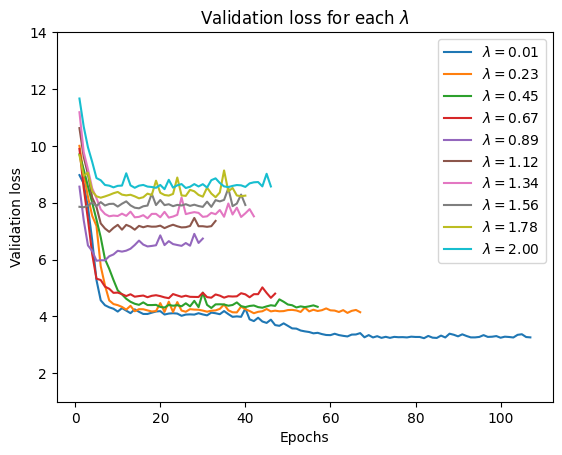

In [4]:
# Grid search plot
for i, val_losses in enumerate(all_val_losses):
  plt.plot(range(1, len(val_losses) + 1), val_losses, label=f"$\lambda={lambdas[i]:.2f}$")
plt.xlabel('Epochs')
plt.ylabel('Validation loss')
plt.title(r"Validation loss for each $\lambda$")
plt.ylim([1, 14])
plt.legend()
plt.show()



In [5]:
# Update lambda
set_seed(SEED)

# Generate the data
x_train, y_train = data_generating(N_TRAIN)
x_val, y_val = data_generating(N_VAL)

# Create datasets and dataloaders
train_dat = TensorDataset(x_train, y_train)
val_dat = TensorDataset(x_val, y_val)

train_loader = DataLoader(dataset=train_dat, shuffle=True, batch_size=BATCH_SIZE)
val_loader = DataLoader(dataset=val_dat, shuffle=True, batch_size=BATCH_SIZE)

x_train, y_train, x_val, y_val = x_train.to(device), y_train.to(device), x_val.to(device), y_val.to(device)

lambdas = np.linspace(0.01, 2, 10)

all_val_losses = []
all_l2s = []
for lam in lambdas:
    model = nn.Sequential(nn.Linear(5, 4),
                      nn.ReLU(),
                      nn.Linear(4, 2),
                      nn.ReLU(),
                      nn.Linear(2, 1)).to(device)
    l2 = torch.nn.Parameter(torch.tensor(lam, requires_grad=True))
    val_losses, l2s = train_mod(model, train_loader, val_loader, l2, BETA, MIN_DELTA, PATIENCE, NUM_EPOCHS, True)
    all_val_losses.append(val_losses)
    all_l2s.append(l2s)

with open('ho_val_losses.pkl', 'wb') as f:
    pickle.dump(all_val_losses, f)

with open('lambda_vals.pkl', 'wb') as f:
    pickle.dump(all_l2s, f)

Early stopping at lambda = -4.9960442843773265: No improvement in validation loss.
Early stopping at lambda = -5.060037178968063: No improvement in validation loss.
Early stopping at lambda = -4.723711347361251: No improvement in validation loss.
Early stopping at lambda = -5.095307555126679: No improvement in validation loss.
Early stopping at lambda = -5.131016369631059: No improvement in validation loss.
Early stopping at lambda = -4.937889717371003: No improvement in validation loss.
Early stopping at lambda = -4.84397069978705: No improvement in validation loss.
Early stopping at lambda = -4.936265514936782: No improvement in validation loss.
Early stopping at lambda = -5.169422855195161: No improvement in validation loss.
Early stopping at lambda = -4.728771656879266: No improvement in validation loss.


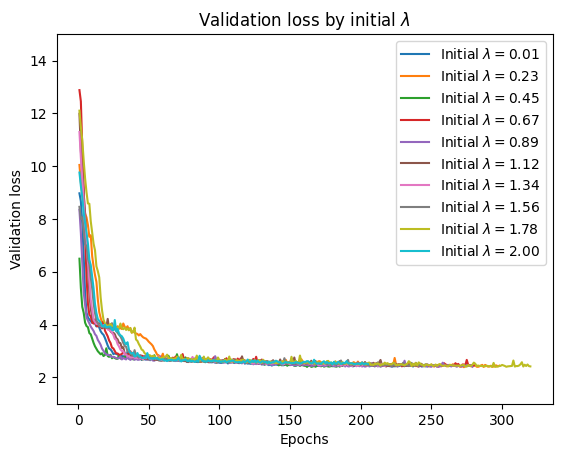

In [6]:
for i, val_losses in enumerate(all_val_losses):
  plt.plot(range(1, len(val_losses) + 1), val_losses, label=f"Initial $\lambda={lambdas[i]:.2f}$")
plt.xlabel('Epochs')
plt.ylabel('Validation loss')
plt.title(r"Validation loss by initial $\lambda$")
plt.ylim([1, 15])
plt.legend()
plt.show()

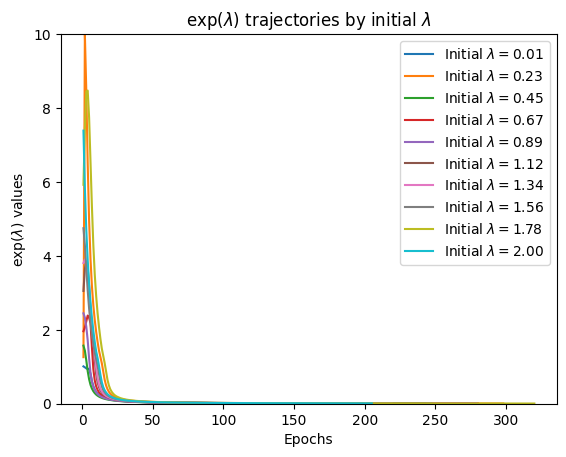

In [7]:
for i, l2_vals in enumerate(all_l2s):
  plt.plot(range(1, len(l2_vals) + 1), np.exp(l2_vals), label=f"Initial $\lambda={lambdas[i]:.2f}$")
plt.xlabel('Epochs')
plt.ylabel(r"$\exp(\lambda)$ values")
plt.title(r"$\exp(\lambda)$ trajectories by initial $\lambda$")
plt.ylim([0, 10])
# plt.xlim([0, 10])
plt.legend()
plt.show()

## Timing

In [8]:
%%timeit
set_seed(SEED)

# Generate the data
x_train, y_train = data_generating(N_TRAIN)
x_val, y_val = data_generating(N_VAL)

# Create datasets and dataloaders
train_dat = TensorDataset(x_train, y_train)
val_dat = TensorDataset(x_val, y_val)

train_loader = DataLoader(dataset=train_dat, shuffle=True, batch_size=BATCH_SIZE)
val_loader = DataLoader(dataset=val_dat, shuffle=True, batch_size=BATCH_SIZE)

lambdas = np.linspace(0.01, 2, 10)


for l in lambdas:
    model = nn.Sequential(nn.Linear(5, 4),
                      nn.ReLU(),
                      nn.Linear(4, 2),
                      nn.ReLU(),
                      nn.Linear(2, 1)).to(device)
    val_losses, _ = train_mod(model, train_loader, val_loader, l, BETA, MIN_DELTA, PATIENCE, NUM_EPOCHS)

Early stopping at lambda = 0.01: No improvement in validation loss.
Early stopping at lambda = 0.23111111111111113: No improvement in validation loss.
Early stopping at lambda = 0.45222222222222225: No improvement in validation loss.
Early stopping at lambda = 0.6733333333333333: No improvement in validation loss.
Early stopping at lambda = 0.8944444444444445: No improvement in validation loss.
Early stopping at lambda = 1.1155555555555556: No improvement in validation loss.
Early stopping at lambda = 1.3366666666666667: No improvement in validation loss.
Early stopping at lambda = 1.557777777777778: No improvement in validation loss.
Early stopping at lambda = 1.778888888888889: No improvement in validation loss.
Early stopping at lambda = 2.0: No improvement in validation loss.
Early stopping at lambda = 0.01: No improvement in validation loss.
Early stopping at lambda = 0.23111111111111113: No improvement in validation loss.
Early stopping at lambda = 0.45222222222222225: No improve

In [10]:
%%timeit
set_seed(SEED)

# Generate the data
x_train, y_train = data_generating(N_TRAIN)
x_val, y_val = data_generating(N_VAL)

# Create datasets and dataloaders
train_dat = TensorDataset(x_train, y_train)
val_dat = TensorDataset(x_val, y_val)

train_loader = DataLoader(dataset=train_dat, shuffle=True, batch_size=BATCH_SIZE)
val_loader = DataLoader(dataset=val_dat, shuffle=True, batch_size=BATCH_SIZE)

x_train, y_train, x_val, y_val = x_train.to(device), y_train.to(device), x_val.to(device), y_val.to(device)

lambdas = 0.1

model = nn.Sequential(nn.Linear(5, 4),
                      nn.ReLU(),
                      nn.Linear(4, 2),
                      nn.ReLU(),
                      nn.Linear(2, 1)).to(device)
l2 = torch.nn.Parameter(torch.tensor(lambdas, requires_grad=True))
val_losses, l2s = train_mod(model, train_loader, val_loader, l2, BETA, MIN_DELTA, PATIENCE, NUM_EPOCHS, True)

Early stopping at lambda = -5.155413627624512: No improvement in validation loss.
Early stopping at lambda = -5.155413627624512: No improvement in validation loss.
Early stopping at lambda = -5.155413627624512: No improvement in validation loss.
Early stopping at lambda = -5.155413627624512: No improvement in validation loss.
Early stopping at lambda = -5.155413627624512: No improvement in validation loss.
Early stopping at lambda = -5.155413627624512: No improvement in validation loss.
Early stopping at lambda = -5.155413627624512: No improvement in validation loss.
Early stopping at lambda = -5.155413627624512: No improvement in validation loss.
10min 36s ± 4.19 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [11]:
# PyTorch version
print("\nPyTorch version")
print(torch.__version__)

# CUDA information
print("\nCUDA information")
print("CUDA available:", torch.cuda.is_available())
print("CUDA version:", torch.version.cuda)
print("Number of GPUs:", torch.cuda.device_count())
if torch.cuda.is_available():
    print("Current GPU:", torch.cuda.get_device_name(torch.cuda.current_device()))



PyTorch version
2.0.1+cu118

CUDA information
CUDA available: True
CUDA version: 11.8
Number of GPUs: 1
Current GPU: Tesla T4
